# Finite Element Tutorial - Validation with Analytical Solution

This tutorial demonstrates the validation of fenicsX simulation results with analytical results for a simple system. It is a slight modification from the fenicsX example found at https://github.com/Lejeune-Lab-Graduate-Course-Materials/fenicsX/blob/main/automation_example/script.py.

Consider a beam with length L, modulus E, and second moment of area I. Let it be fixed at both ends, and apply a uniform applied load q.

<img src="a-beam_diagram.png" alt="Beam Diagram" width="500"/>

The analytical solution for the deflection at a distance x along the beam is then given by

$\delta_{max} = \frac{q x^2}{24 E I} \left(L - x^2\right)$

(Image and formula from https://structx.com/Beam_Formulas_015.html, retrieved 4/25)

## Dependency Importing





In [54]:
import os
from dolfinx import default_scalar_type, fem, log, mesh, plot
from dolfinx.io import gmshio
from dolfinx.nls.petsc import NewtonSolver
from dolfinx.fem.petsc import NonlinearProblem
from mpi4py import MPI
import numpy as np
import pyvista
import matplotlib.pyplot as plt
import ufl
import fenicsX.automation_example.utils as utils

## Geometry and Mesh Setup

We model only half the beam, for computational efficiency, leaving the end representing the middle free to move vertically (but fixed horizontally). A fine mesh with matching length scales in the x and y directions should provide accurate results.

In [55]:
length = 2.0
width = 0.2
b = 4 # beam thickness in z-direction (Note - does not change simulation)
Inertia = b*width**3/12

amplitude = 0
frequency = 0
n_points = 100

mesh_name = "rectangle.msh"
mesh_size = 0.1

Nx = 100
Ny = 5
#mesh_obj = mesh.create_rectangle(MPI.COMM_WORLD, points=np.array([[0, 0], [length, width]]), n=[Nx, Ny], diagonal=mesh.DiagonalType.crossed)

outline_points = utils.generate_sine_distorted_rectangle(length, width, amplitude, frequency, n_points)
utils.plot_outline("a-outline.png", outline_points)
utils.generate_and_save_linear_mesh(outline_points, mesh_name, mesh_size, mesh_name)
domain, cell_tags, facet_tags = gmshio.read_from_msh(mesh_name, comm=MPI.COMM_WORLD, gdim=2)


Linear mesh saved to: /projectnb/me700/students/keenanw7/BU_ENGME700_KeenanWood_A4/2-Assignment_4_Tutorials/rectangle.msh
Info    : Reading 'rectangle.msh'...
Info    : 1214 nodes
Info    : 2426 elements
Info    : Done reading 'rectangle.msh'
[2025-04-28 13:03:25.020] [info] Extract basic topology: 6672->6672
[2025-04-28 13:03:25.020] [info] Build local dual graph
[2025-04-28 13:03:25.020] [info] Build local part of mesh dual graph (mixed)
[2025-04-28 13:03:25.022] [info] GPS pseudo-diameter:(195) 2148-2138
[2025-04-28 13:03:25.022] [info] Create topology (single cell type)
[2025-04-28 13:03:25.022] [info] Create topology (generalised)
[2025-04-28 13:03:25.022] [info] Computing communication graph edges (using NBX algorithm). Number of input edges: 1
[2025-04-28 13:03:25.022] [info] Finished graph edge discovery using NBX algorithm. Number of discovered edges 1
[2025-04-28 13:03:25.023] [info] Compute ghost indices
[2025-04-28 13:03:25.023] [info] Computing communication graph edges (u

<img src="a-outline.png" alt="Beam Outline" width="500"/>

## Define Function Space for Vector Displacement

In [56]:
V = fem.functionspace(domain, ("Lagrange", 1, (domain.geometry.dim,)))
v = ufl.TestFunction(V)
u = fem.Function(V, name="Displacement")

[2025-04-28 13:03:25.040] [info] Checking required entities per dimension
[2025-04-28 13:03:25.040] [info] Cell type: 0 dofmap: 2224x3
[2025-04-28 13:03:25.040] [info] Global index computation
[2025-04-28 13:03:25.040] [info] Got 1 index_maps
[2025-04-28 13:03:25.040] [info] Get global indices


## Initialize Material Model

In [57]:
mu = 134.6
K = 83.33
#mu = E / (2*(1 + v))
#K = E / (3*(1 - 2*v))
nu = (3*mu/K - 2) / (2 + 6*mu/K)
E = mu * 2*(1 + nu)

nu = 0.3
mu = fem.Constant(domain, E / (2 * (1 + nu)))
lmbda = fem.Constant(domain, E * nu / ((1 + nu) * (1 - 2 * nu)))

d = domain.geometry.dim
I = ufl.Identity(d)
F = ufl.variable(I + ufl.grad(u))
J = ufl.det(F)
C = F.T * F
I1 = ufl.tr(C)
psi = (mu / 2) * (I1 - 3) - mu * ufl.ln(J) + (lmbda / 2) * ufl.ln(J)**2
P = ufl.diff(psi, F)

![](a-mesh.png "Beam Mesh")

## Specify Boundary Conditions and Applied Loads

To limit only the horizontal motion of the end of the beam representing the middle, we specify an x-velocity of 0 and a y-velocity of None.

In [58]:
def left(x): return np.isclose(x[0], 0.0, atol=1e-5)


def right(x): return np.isclose(x[0], length, atol=1e-5)


fdim = domain.topology.dim - 1
left_facets = mesh.locate_entities_boundary(domain, fdim, left)
right_facets = mesh.locate_entities_boundary(domain, fdim, right)

marked_facets = np.hstack([left_facets, right_facets])
marked_values = np.hstack([np.full_like(left_facets, 1),
                          np.full_like(right_facets, 2)])
sorted_facets = np.argsort(marked_facets)
facet_tag = mesh.meshtags(domain, fdim, marked_facets[sorted_facets],
                          marked_values[sorted_facets])

u_bc = np.array((0,) * domain.geometry.dim, dtype=default_scalar_type)
left_dofs = fem.locate_dofs_topological(V, facet_tag.dim, facet_tag.find(1))
right_dofs = fem.locate_dofs_topological(V, facet_tag.dim, facet_tag.find(2))
bcs = [fem.dirichletbc(u_bc, left_dofs, V), fem.dirichletbc(u_bc, right_dofs, V)]

# Apply the uniform distributed load; Create body and traction forces
q = -0.01
B = fem.Constant(domain, default_scalar_type((0, q)))
T = fem.Constant(domain, default_scalar_type((0, 0)))

[2025-04-28 13:03:25.057] [info] Requesting connectivity (1, 0) - (2, 0)
[2025-04-28 13:03:25.057] [info] Requesting connectivity (1, 0) - (0, 0)
[2025-04-28 13:03:25.057] [info] Requesting connectivity (1, 0) - (1, 0)
[2025-04-28 13:03:25.058] [info] Requesting connectivity (0, 0) - (2, 0)
[2025-04-28 13:03:25.058] [info] Computing mesh connectivity 0-2 from transpose.
[2025-04-28 13:03:25.058] [info] Requesting connectivity (2, 0) - (0, 0)
[2025-04-28 13:03:25.058] [info] Requesting connectivity (1, 0) - (2, 0)
[2025-04-28 13:03:25.058] [info] Requesting connectivity (1, 0) - (0, 0)
[2025-04-28 13:03:25.058] [info] Requesting connectivity (1, 0) - (1, 0)
[2025-04-28 13:03:25.058] [info] Requesting connectivity (0, 0) - (2, 0)
[2025-04-28 13:03:25.058] [info] Requesting connectivity (2, 0) - (0, 0)


## Build Variational Form

In [59]:
metadata = {"quadrature_degree": 4}
ds = ufl.Measure("ds", domain=domain, subdomain_data=facet_tag, metadata=metadata)
dx = ufl.Measure("dx", domain=domain, metadata=metadata)
F_form = ufl.inner(ufl.grad(v), P) * dx - ufl.inner(v, B) * dx - ufl.inner(v, T) * ds(2)

## Setup Solver

In [60]:
problem = NonlinearProblem(F_form, u, bcs)
solver = NewtonSolver(domain.comm, problem)
solver.atol = 1e-8
solver.rtol = 1e-8
solver.convergence_criterion = "incremental"

[2025-04-28 13:03:25.078] [info] Requesting connectivity (1, 0) - (2, 0)
[2025-04-28 13:03:25.078] [info] Requesting connectivity (2, 0) - (1, 0)
[2025-04-28 13:03:25.078] [info] Requesting connectivity (1, 0) - (2, 0)
[2025-04-28 13:03:25.078] [info] Requesting connectivity (2, 0) - (1, 0)
[2025-04-28 13:03:25.082] [info] Requesting connectivity (1, 0) - (2, 0)
[2025-04-28 13:03:25.082] [info] Requesting connectivity (2, 0) - (1, 0)
[2025-04-28 13:03:25.083] [info] Column ghost size increased from 0 to 0


## Setup Visualizer; Run the Solver and Plot the Results

In [61]:
pyvista.start_xvfb()
plotter = pyvista.Plotter(window_size=(800, 600), off_screen=True, 
                          notebook=False, shape=(1,1), title="2D FEniCSx Plot", 
                          lighting=None)
plotter.open_gif("a-deformation.gif", fps=25)

topology, cells, geometry = plot.vtk_mesh(u.function_space)
function_grid = pyvista.UnstructuredGrid(topology, cells, geometry)

# Prepare 3D vectors for PyVista by appending a zero z-component
values = np.zeros((geometry.shape[0], 3))
u_vals = u.x.array.reshape(geometry.shape[0], -1)
values[:, :u_vals.shape[1]] = u_vals  # Typically, u_vals.shape[1] == 2
function_grid["u"] = values
function_grid.set_active_vectors("u")

# Warp only in-plane (avoid any artificial out-of-plane deformation)
warped = function_grid.warp_by_vector("u", factor=1.0)
warped.points[:, 2] = 0.0  # Ensure all points lie in the 2D plane (z=0)

warped.set_active_vectors("u")
actor = plotter.add_mesh(warped, show_edges=False, lighting=False, clim=[0, 10])


Vs = fem.functionspace(domain, ("Lagrange", 1))
magnitude = fem.Function(Vs)
us = fem.Expression(ufl.sqrt(sum([u[i]**2 for i in range(len(u))])), 
                    Vs.element.interpolation_points())
magnitude.interpolate(us)
warped["mag"] = magnitude.x.array

# FenicsX Simulation
log.set_log_level(log.LogLevel.INFO)
tval0 = 500
for n in range(1, 100):
    T.value[0] = n * tval0
    num_its, converged = solver.solve(u)
    assert converged
    u.x.scatter_forward()
    print(f"Time step {n}, Number of iterations {num_its}, Load {T.value}")
    function_grid["u"][:, :len(u)] = u.x.array.reshape(geometry.shape[0], len(u))
    magnitude.interpolate(us)
    warped.set_active_scalars("mag")
    warped_n = function_grid.warp_by_vector(factor=1)
    warped.points[:, :] = warped_n.points
    warped.point_data["mag"][:] = magnitude.x.array
    plotter.update_scalar_bar_range([0, 12])
    plotter.view_xy()
    if n == 1:
        plotter.reset_camera()
        plotter.camera.Zoom(0.7)
        saved_camera = plotter.camera_position
    else:
        plotter.camera_position = saved_camera
        plotter.camera.Zoom(0.7)
    plotter.write_frame()

plotter.close()

[2025-04-28 13:03:28.141] [info] Checking required entities per dimension
[2025-04-28 13:03:28.141] [info] Cell type: 0 dofmap: 2224x3
[2025-04-28 13:03:28.142] [info] Global index computation
[2025-04-28 13:03:28.142] [info] Got 1 index_maps
[2025-04-28 13:03:28.142] [info] Get global indices
[2025-04-28 13:03:28.152] [info] PETSc Krylov solver starting to solve system.
[2025-04-28 13:03:28.161] [info] PETSc Krylov solver starting to solve system.
Time step 1, Number of iterations 3, Load [500.   0.]
[2025-04-28 13:03:28.165] [info] Newton iteration 2: r (abs) = 4.150389769686339e-07 (tol = 1e-08), r (rel) = 4.840748316866823e-05 (tol = 1e-08)
[2025-04-28 13:03:28.168] [info] PETSc Krylov solver starting to solve system.
[2025-04-28 13:03:28.172] [info] Newton iteration 3: r (abs) = 2.2847561306504614e-13 (tol = 1e-08), r (rel) = 2.66479294900855e-11 (tol = 1e-08)
[2025-04-28 13:03:28.172] [info] Newton solver finished in 3 iterations and 3 linear solver iterations.
[2025-04-28 13:03:

<img src="a-deformation.gif" alt="Beam Deformation" width="500"/>

## Compute the Analytical Results and Plot a Comparison

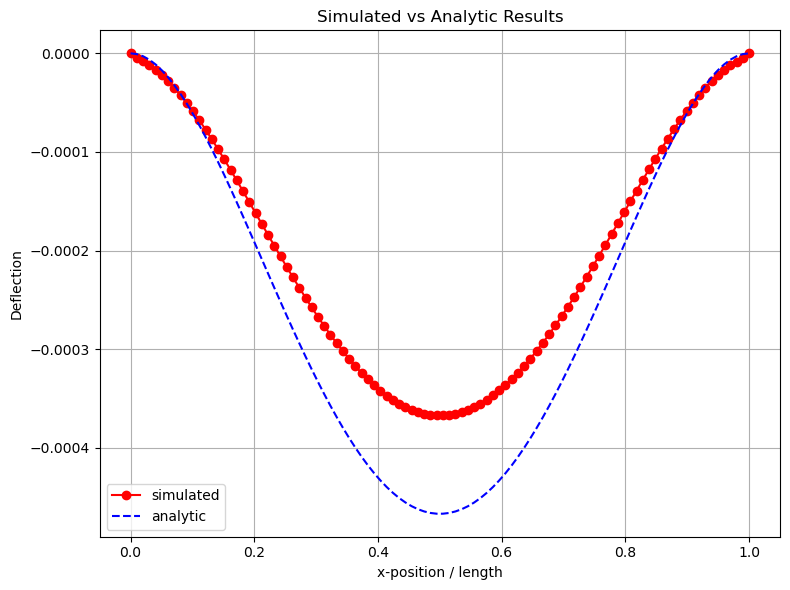

In [62]:
# Analytical solution: u_y(x)
x_vals = np.linspace(0, length, 100)
analytical_u_y = q*np.square(x_vals)/(24*E*Inertia) * (length-x_vals)**2
centerline_points = [(x_val, 0, 0) for x_val in x_vals]
sim_u_vals = utils.get_centerline_displacement(u, centerline_points, domain, tol=1e-10)
sim_u_y = [coords[1] for coords in sim_u_vals]

# Plot the max deflection values computed for each mesh size and element type
plt.figure(figsize=(8, 6))
plt.plot(x_vals / length, sim_u_y, 'ro-', label="simulated")
plt.plot(x_vals / length, analytical_u_y, 'b--', label="analytic")
plt.xlabel("x-position / length")
plt.ylabel("Deflection")
plt.title("Simulated vs Analytic Results")
plt.legend()
plt.grid(True)
plt.tight_layout()

# Save the plot image
tutorials_dir = os.path.abspath('')
img_fname = tutorials_dir + "/a-analytic-comparison.png"
plt.savefig(str(img_fname))

The results show agreement, but there still seems to be a noticeable difference in the maximum deflection in the middle of the beam. It seems that this may be due to a mismatch in beam stiffness parameters between the analytical model and simulations, or in improperly-applied clamped boundary conditions.